# 1 - Descarga y Exploracion del corpus



In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import random 

import sys
sys.path.append('../..')

#from utils import load_cinema_reviews

import random
random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

import matplotlib.pyplot as plt

Cargamos el dataset

In [4]:
df = pd.read_json(path_or_buf='/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/Video_Games_5.json', lines=True)

Unimos las columnas summary y reviewText ya que ambas van a contribuir a formar nuestro vocabulario

In [5]:
df['reviewText'] = df['reviewText'] + str(". ") + df['summary']

Etiquetamos las reviews en positiva y negativa. Consideraremos positivo todo lo que sea mayor a dos estrellas

In [6]:
def label(x):
  if x >2:
    return 1 #positiva
  else:
    return 0 #negativa

df['label'] = df['overall'].apply(lambda x: label(x))

### 1.1 Distribucion de reviews por numero de estrellas y por polaridad  (positivas/negativas)

Empezamos con este punto en el análisis exploratorio ya que nos permite deshacernos de una parte de las reviews y asi a la vez:
 para equilibrar el numero de review positivas con las negativas para facilitar 

1.   Equlibrar el numeros de reviews positivas con el numero de reviews negativas (lo que es bueno para que el algoritmo de ML aprenda correctamente)
2.   Eliminamos el tamaño del corpus que de otra forma nos resulta intratable con los recursos computacionales disponibles

Empezamos con la distribucion por el numero de estrellas

Hay 120185 reviews con 5 estrellas
Hay 54804 reviews con 4 estrellas
Hay 28275 reviews con 3 estrellas
Hay 13663 reviews con 2 estrellas
Hay 14853 reviews con 1 estrellas




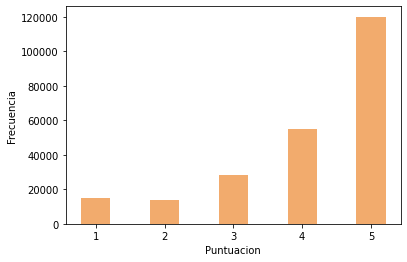

In [7]:
plot.hist(x=df['overall'], bins=[0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25], color='#F2AB6D', rwidth=0.85)
plot.title('')
plot.xlabel('Puntuacion')
plot.ylabel('Frecuencia')

print("Hay {} reviews con 5 estrellas".format(len(df[df['overall'] == 5])))
print("Hay {} reviews con 4 estrellas".format(len(df[df['overall'] == 4])))
print("Hay {} reviews con 3 estrellas".format(len(df[df['overall'] == 3])))
print("Hay {} reviews con 2 estrellas".format(len(df[df['overall'] == 2])))
print("Hay {} reviews con 1 estrellas".format(len(df[df['overall'] == 1])))
print("\n")

Seguimos con la distribucion de reviews positivas y negativas

Hay 203264 reviews positivas
Hay 28516 reviews negativas




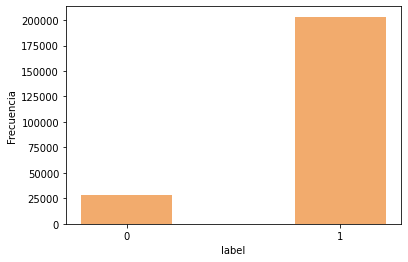

In [8]:
plot.hist(x=df['label'], bins=[-0.25, 0.25, 0.75, 1.25], color='#F2AB6D', rwidth=0.85)
plot.title('')
plot.xlabel('label')
plot.ylabel('Frecuencia')
plot.xticks([0,1])
print("Hay {} reviews positivas".format(len(df[df['label'] == 1])))
print("Hay {} reviews negativas".format(len(df[df['label'] == 0])))
print("\n")

Se observa un gran desbalanceo por lo que vamos a liminar tantas reviews positivas (1) como ean nevesarias para igualar al numero de reviews negativas

In [9]:
idx = df.index[df['label']==1].tolist()
drop_idx = random.sample(idx, (len(df[df['label']==1])-len(df[df['label']==0])))
df = df.drop(drop_idx)
df = df.reset_index(drop=True)

Hacemos en este momento la separación entre train y test para evitar data leaking en los siguientes pasos

In [10]:
df_train, df_test = train_test_split(df, train_size=0.75, test_size=0.25, random_state=42, shuffle=True)

Comprobamos que el dataset de train tiene una distribucion apropiada de casos positivos y negativos para asegurarnose de que el entrenamiento del modelo sea apropiado

In [11]:
df_train['label'].value_counts()

1    21394
0    21380
Name: label, dtype: int64

### 1.2 - Tratamiento de outliers (numero de palabras/review)



Hay un 2.23 % de reviews con más de 1000 palabras
Hay un 0.08 % de reviews con menos de 20 palabras




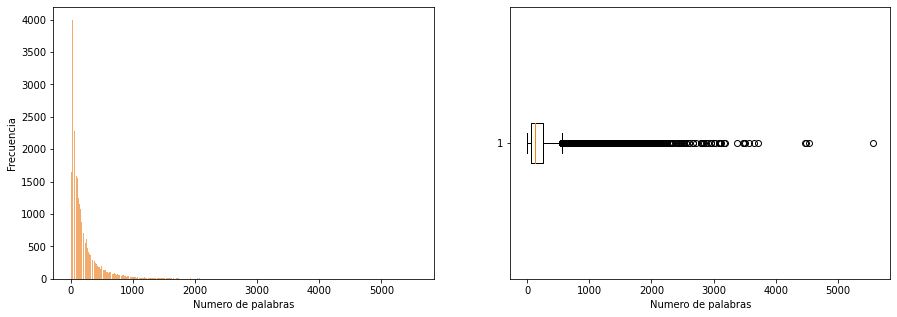

In [12]:
def word_counter (x):
  doc = x.split()
  return len(doc)

Len_text = df_train["reviewText"].apply(lambda x: word_counter(x))

plt.figure(figsize=(15, 5))  
plt.subplot(1,2,1)
plot.hist(x=Len_text, bins=500, color='#F2AB6D', rwidth=0.85)
plot.title('')
plot.xlabel('Numero de palabras')
plot.ylabel('Frecuencia')
#plot.xticks([0,100000])

plt.subplot(1,2,2)
plt.boxplot(Len_text, vert=False)
plt.xlabel('Numero de palabras')
print("\n")


print("Hay un {} % de reviews con más de 1000 palabras".format(round(len(Len_text[Len_text> 1000])/len(Len_text)*100,2)))
print("Hay un {} % de reviews con menos de 20 palabras".format(round(len(Len_text[Len_text< 5])/len(Len_text)*100,2)))
print("\n")

Se observan múltiples outliers por encoma de . Puede ser una buena opcion quitar los textos de más de 1000 palabras y los de menos de 20 ya que representan menos del 3% y por lo tanto representan un outlier.

### 1.2 - Hayamos la cardinalidad del vocabulario y los ngramas más frecuentes




In [13]:
from collections import Counter

In [14]:
corpus = df_train['reviewText'].str.cat(sep='')

In [15]:
words_nltk = corpus.lower().split()
word = Counter(words_nltk)

In [16]:
print("Nuestro vocabulario inicial consta de {} palabras diferentes".format(len(word.most_common())))

Nuestro vocabulario inicial consta de 346490 palabras diferentes


Mostramos la distribución de palabras más frecuentes

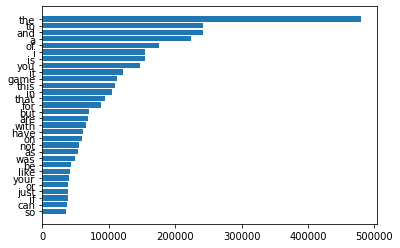

In [17]:
from collections import Counter
wf = Counter(words_nltk)
wf_most_common = wf.most_common(30)
words = [w[0] for w in wf_most_common]
freqs = [w[1] for w in wf_most_common]
freqs, words = zip(*sorted(zip(freqs, words)))

plt.barh(words, freqs)
plt.show()

Estas son potenciales stopwords, ya que aparecen mucho y no parecen tener una relación directa con la polaridad de las reviews. En la segunda parte del ejercicio veremos de cuales nos deshacemos, ya que la función Tdif se deshara de muchas directamente por su alta concurrencia

Hacemos la cuenta de los bigramas y trigramas más frecuentes y los ploteamos

In [18]:
from nltk import ngrams
from nltk.probability import FreqDist

bigrams_ = list(ngrams(words_nltk, 2))
trigrams_ = list(ngrams(words_nltk, 3))
bg_freq = FreqDist(bigrams_)
tg_freq = FreqDist(trigrams_)
bg_freq.most_common(10)
tg_freq.most_common(10)
bg_freq_most_common = bg_freq.most_common(10)
bgs_ = [str(bg[0]) for bg in bg_freq_most_common]
bgs_f_ = [bg[1] for bg in bg_freq_most_common]

tg_freq_most_common = tg_freq.most_common(10)
tgs_ = [str(tg[0]) for tg in tg_freq_most_common]
tgs_f_ = [tg[1] for tg in tg_freq_most_common]
bgs_f_, bgs_ = zip(*sorted(zip(bgs_f_, bgs_)))
tgs_f_, tgs_ = zip(*sorted(zip(tgs_f_, tgs_)))

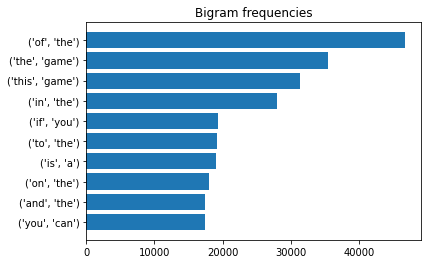

In [19]:
plt.barh(bgs_, bgs_f_)
plt.title('Bigram frequencies')
plt.show()

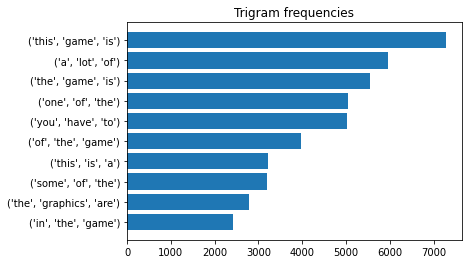

In [20]:
plt.barh(tgs_, tgs_f_)
plt.title('Trigram frequencies')
plt.show()

De la misma forma que con las palabras, los ngramas mas frecuentes tienen en general poca relación con la polaridad del texto así que esperamos deshacernos de ellos en el futuro

Observamos el parámetro chi2 para saber que n-gramas tienen un peso alto en el análisis, y no deberían, ya que no expresan polaridad (por lo que pueden inducir a una predicción erronea). Y tambien analizamos las palabras que tienen un peso bajo en el análisis y viendo los plots de frecuencia anteriores se detecta que aparecen mucho (por lo que pueden cosiderarse stopwords).

In [21]:
vectorizer = TfidfVectorizer(ngram_range=(1,4))
X = vectorizer.fit_transform(df_train["reviewText"])

N-gramas con mayor valor de chi2

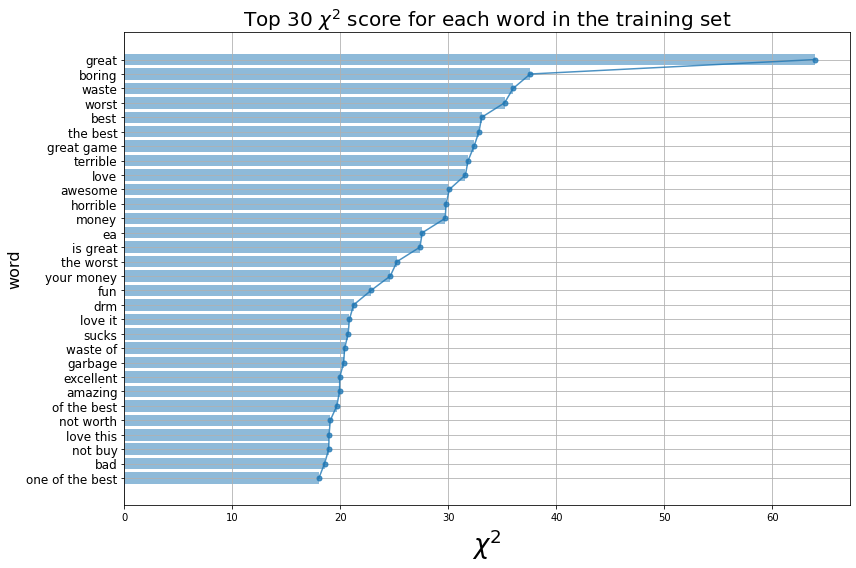

In [ ]:
#Temporal


i = 30

chi2score = chi2(X, df_train["label"])[0]
scores = list(zip(vectorizer.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

N-gramas con menor valor de chi2

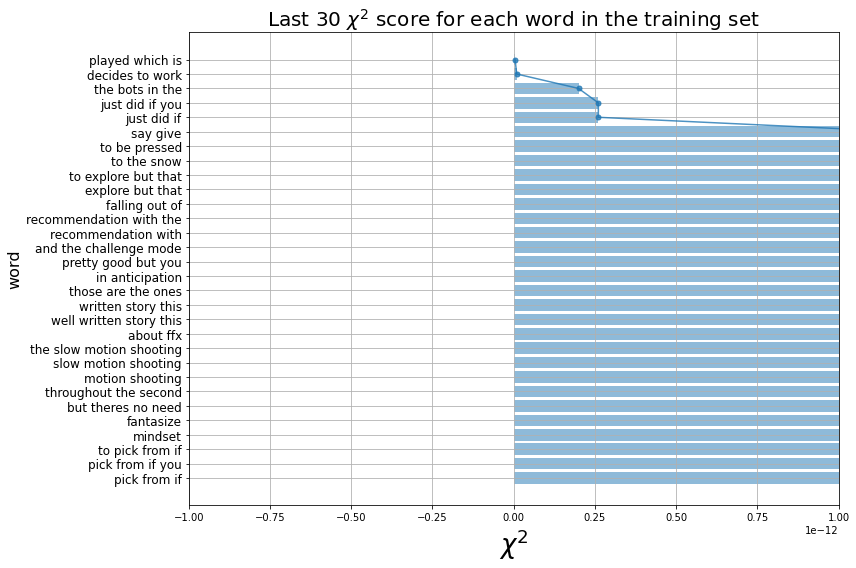

In [24]:
i = 30

chi2score = chi2(X, df_train["label"])[0]
scores = list(zip(vectorizer.get_feature_names(), chi2score))
sorted_scores = sorted(scores, key=lambda x:x[1], reverse=True)
topchi2 = list(zip(*sorted_scores[-i:]))
x = range(len(topchi2[1]))
labels = topchi2[0]

plt.figure(figsize=(12, 8))
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Last {} $\chi^2$ score for each word in the training set'.format(i), fontsize=20)
plt.grid()
plt.tight_layout()
plt.show();

Las palabras "ea", "drm", "money", "your money" son palabras que no necesariamente contribuyen a la predicción correcta de la polaridad, por lo que tendran que ser planteadas como stopwords o hacer algun tipo de tratamiento en el siguiente paso.

No se saca una conclusión clara de las palabras con chi2 bajo, mas alla de que se espera que todas las palabras con chi proximo a cero sean incluidas como stopwords

### 1.3 - Nubes de palabras

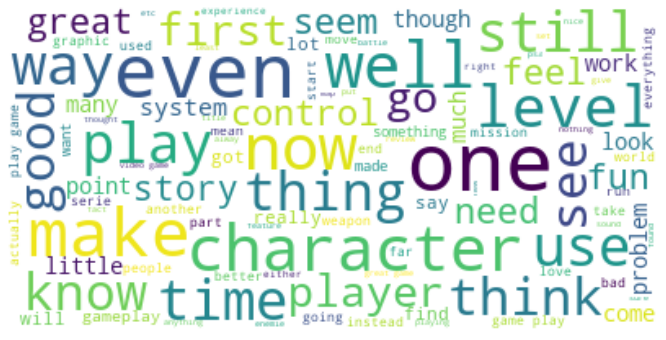

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def plot_word_cloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(' '.join(text))
    plt.figure( figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

words_list = corpus.lower().strip().split()
plot_word_cloud(words_list)

### 1.4 - Tratamiento de outliers (numero de palabras/review)

Hay un 2.23 % de reviews con más de 1000 palabras
Hay un 0.77 % de reviews con menos de 20 palabras


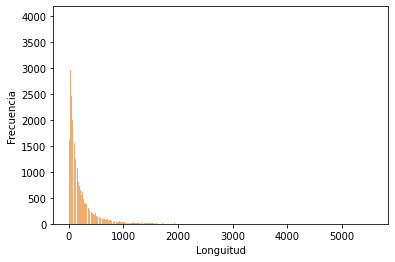

In [ ]:
def word_counter (x):
  doc = x.split()
  return len(doc)

Len_text = df_train["reviewText"].apply(lambda x: word_counter(x))
plot.hist(x=Len_text, bins=500, color='#F2AB6D', rwidth=0.85)
plot.title('')
plot.xlabel('Longuitud')
plot.ylabel('Frecuencia')
#plot.xticks([0,100000])

print("Hay un {} % de reviews con más de 1000 palabras".format(round(len(Len_text[Len_text> 1000])/len(Len_text)*100,2)))
print("Hay un {} % de reviews con menos de 20 palabras".format(round(len(Len_text[Len_text< 20])/len(Len_text)*100,2)))
print("\n")

Puede ser una buena opcion quitar los textos de más de 1000 palabras y los de menos de 20 ya que representan menos del 3% y por lo tanto representan un outlier. 

### 1.5 - Visualización en 2 dimensions (Word2Vec)

In [ ]:
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence

In [ ]:
#Solo se utiliza una vez para guardar el corpus en un .txt
idx_rd =random.sample(df_train.index.tolist(), 10000)
corpus = df_train['reviewText'][idx_rd].str.cat(sep='')
with open("corpus.txt", "w") as text_file:
   text_file.write(corpus)

In [ ]:
corpus = df_train['reviewText'].str.cat(sep='')
with open("corpus.txt", "w") as text_file:
   text_file.write(corpus)

w2v_sg = Word2Vec(size=200, window=10, min_count= 5, sg = 0, hs = 0, negative = 20)
corpus = LineSentence("corpus.txt", limit = 100)
w2v_sg.build_vocab(corpus)
print('Vocabulario compuesto por {} palabras'.format(len(w2v_sg.wv.vocab)))

Vocabulario compuesto por 19501 palabras


Vamos a reducir la dimensionalidad para poder representar las palabras en 2D

In [ ]:
keys = ['game', 'ea', 'great', 'level', 'control']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_sg.wv.most_similar(word, topn=5):
        words.append(similar_word)
        embeddings.append(w2v_sg.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

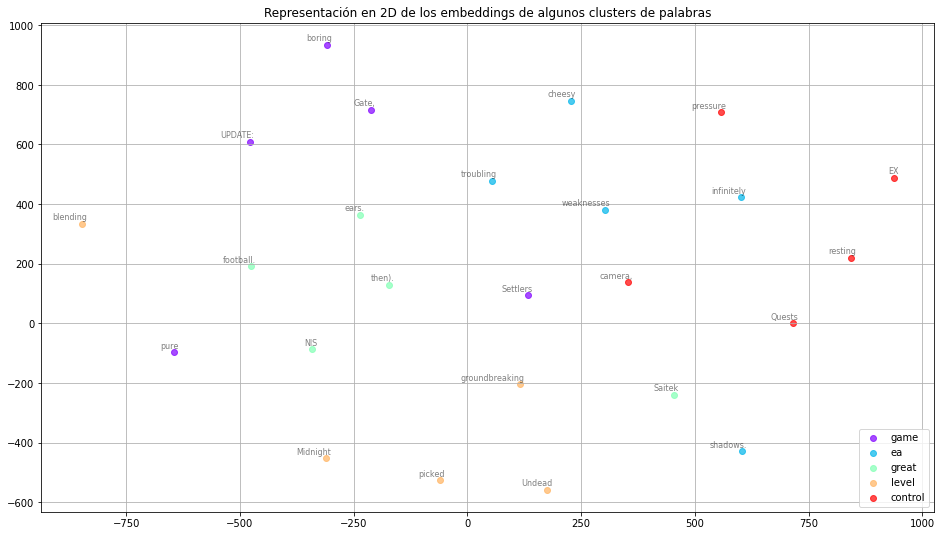

In [ ]:
tsne_model_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape

embeddings_2d = np.array(tsne_model_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.cm as cm
%matplotlib inline


def tsne_plot_similar_words(labels, embedding_clusters, word_clusters, a=0.7):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:,0]
        y = embeddings[:,1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2), 
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.grid(True)
    plt.title('Representación en 2D de los embeddings de algunos clusters de palabras')
    # plt.savefig("f/г.png", format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words(keys, embeddings_2d, word_clusters)

### 1.7 Conclusiones

Tras la visualización sacamos las siguientes conclusiones de cada uno de los apartados :


1.   Hay muchas más reviews positivas que negativas por lo que ya se ha hecho un ajuste para que el sistema aprenda de forma correcta y tambien disminuir así el tamaño del dataset
2.   Los Ngramas más repetidos son en general poco indicadores de la polaridad(como era de esperar). Hay pocas ngramas con un chi2 significativo. Hay ciertas palabras con un valor de chi2 alto que no deberían ser utilizados para determinar la polaridad ("ea", "drm", "money", "your money"). Como opciones se plantea un NER o intentar utilizar Ngramas de dimension 4 o 5 para captar frases del tipo "don't waste your money", " it does not worth your money", etc...

3. Algunas palabras de alto valor en la prediccion de la polaridad ("great", "well", "good", "bad"...) tienen bastante frecuencia en el corpus, lo cual ayudara a nuestras predicciones.

4. Hemos detectado que un 3% de las reviews se situan por encima de las 1000 palabras y por debajo de las 20. Estas reviews pueden ser confusas a la hora de dar una predicción correcta, por lo que las vamos a deshechar.

5. 



Por ultimo guardamos las variables que van a ser utilizadas en el proximo ejercicio

In [ ]:
df_train.to_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/df_train.txt")
df_test.to_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/df_test.txt")

In [ ]:
b=3
a = b
b = 2
print(a)

3
